# Think Bayes: Chapter 7

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [4]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## Warm-up exercises

**Exercise:** Suppose that goal scoring in hockey is well modeled by a 
Poisson process, and that the long-run goal-scoring rate of the
Boston Bruins against the Vancouver Canucks is 2.9 goals per game.
In their next game, what is the probability
that the Bruins score exactly 3 goals?  Plot the PMF of `k`, the number
of goals they score in a game.

In [5]:
# Solution goes here

In [6]:
# Solution goes here

In [7]:
# Solution goes here

**Exercise:**  Assuming again that the goal scoring rate is 2.9, what is the probability of scoring a total of 9 goals in three games?  Answer this question two ways:

1.  Compute the distribution of goals scored in one game and then add it to itself twice to find the distribution of goals scored in 3 games.

2.  Use the Poisson PMF with parameter $\lambda t$, where $\lambda$ is the rate in goals per game and $t$ is the duration in games.

In [8]:
# Solution goes here

In [9]:
# Solution goes here

**Exercise:** Suppose that the long-run goal-scoring rate of the
Canucks against the Bruins is 2.6 goals per game.  Plot the distribution
of `t`, the time until the Canucks score their first goal.
In their next game, what is the probability that the Canucks score
during the first period (that is, the first third of the game)?

Hint: `thinkbayes2` provides `MakeExponentialPmf` and `EvalExponentialCdf`.

In [10]:
# Solution goes here

In [11]:
# Solution goes here

In [12]:
# Solution goes here

**Exercise:** Assuming again that the goal scoring rate is 2.8, what is the probability that the Canucks get shut out (that is, don't score for an entire game)?  Answer this question two ways, using the CDF of the exponential distribution and the PMF of the Poisson distribution.

In [13]:
# Solution goes here

In [14]:
# Solution goes here

## The Boston Bruins problem

The `Hockey` suite contains hypotheses about the goal scoring rate for one team against the other.  The prior is Gaussian, with mean and variance based on previous games in the league.

The Likelihood function takes as data the number of goals scored in a game.

In [15]:
from thinkbayes2 import MakeNormalPmf
from thinkbayes2 import EvalPoissonPmf

class Hockey(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.

        label: string
        """
        mu = 2.8
        sigma = 0.3

        pmf = MakeNormalPmf(mu, sigma, num_sigmas=4, n=101)
        Suite.__init__(self, pmf, label=label)
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

Now we can initialize a suite for each team:

In [16]:
suite1 = Hockey('bruins')
suite2 = Hockey('canucks')

Here's what the priors look like:

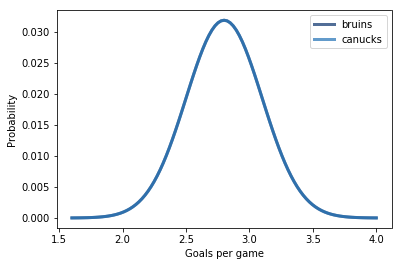

In [17]:
thinkplot.PrePlot(num=2)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

And we can update each suite with the scores from the first 4 games.

(2.8814477910015492, 2.6145205761109502)

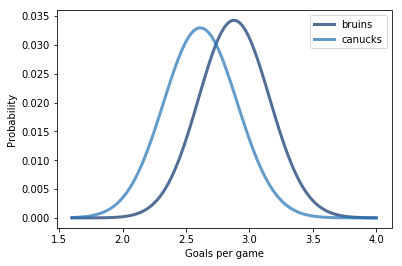

In [18]:
suite1.UpdateSet([0, 2, 8, 4])
suite2.UpdateSet([1, 3, 1, 0])

thinkplot.PrePlot(num=2)
thinkplot.Pdf(suite1)
thinkplot.Pdf(suite2)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

suite1.Mean(), suite2.Mean()

To predict the number of goals scored in the next game we can compute, for each hypothetical value of $\lambda$, a Poisson distribution of goals scored, then make a weighted mixture of Poissons:

In [19]:
from thinkbayes2 import MakeMixture
from thinkbayes2 import MakePoissonPmf

def MakeGoalPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

Here's what the results look like.

(2.879217842090226, 2.6134252104851328)

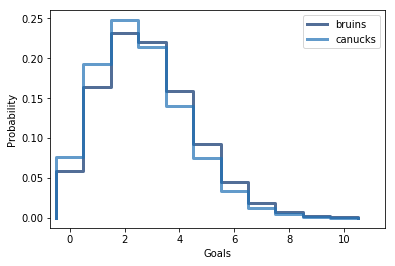

In [20]:
goal_dist1 = MakeGoalPmf(suite1)
goal_dist2 = MakeGoalPmf(suite2)

thinkplot.PrePlot(num=2)
thinkplot.Pmf(goal_dist1)
thinkplot.Pmf(goal_dist2)
thinkplot.Config(xlabel='Goals',
                ylabel='Probability',
                xlim=[-0.7, 11.5])

goal_dist1.Mean(), goal_dist2.Mean()

Now we can compute the probability that the Bruins win, lose, or tie in regulation time.

In [21]:
diff = goal_dist1 - goal_dist2
p_win = diff.ProbGreater(0)
p_loss = diff.ProbLess(0)
p_tie = diff.Prob(0)

print('Prob win, loss, tie:', p_win, p_loss, p_tie)

Prob win, loss, tie: 0.4579997823117246 0.37029032604107404 0.1717098916472006


If the game goes into overtime, we have to compute the distribution of `t`, the time until the first goal, for each team.  For each hypothetical value of $\lambda$, the distribution of `t` is exponential, so the predictive distribution is a mixture of exponentials.

In [22]:
from thinkbayes2 import MakeExponentialPmf

def MakeGoalTimePmf(suite):
    """Makes the distribution of time til first goal.

    suite: distribution of goal-scoring rate

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakeExponentialPmf(lam, high=2.5, n=1001)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

Here's what the predictive distributions for `t` look like.

(0.34678105634353573, 0.3814069850949935)

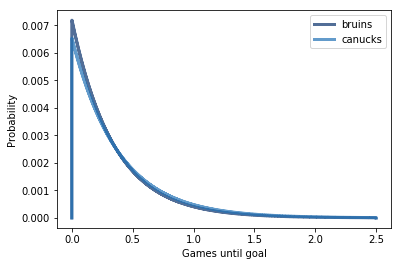

In [23]:
time_dist1 = MakeGoalTimePmf(suite1)    
time_dist2 = MakeGoalTimePmf(suite2)
 
thinkplot.PrePlot(num=2)
thinkplot.Pmf(time_dist1)
thinkplot.Pmf(time_dist2)    
thinkplot.Config(xlabel='Games until goal',
                   ylabel='Probability')

time_dist1.Mean(), time_dist2.Mean()

In overtime the first team to score wins, so the probability of winning is the probability of generating a smaller value of `t`:

In [24]:
p_win_in_overtime = time_dist1.ProbLess(time_dist2)
p_adjust = time_dist1.ProbEqual(time_dist2)
p_win_in_overtime += p_adjust / 2
print('p_win_in_overtime', p_win_in_overtime)

p_win_in_overtime 0.5241451046185259


Finally, we can compute the overall chance that the Bruins win, either in regulation or overtime.

In [25]:
p_win_overall = p_win + p_tie * p_win_in_overtime
print('p_win_overall', p_win_overall)

p_win_overall 0.5480006814331824


## Exercises

**Exercise:** To make the model of overtime more correct, we could update both suites with 0 goals in one game, before computing the predictive distribution of `t`.  Make this change and see what effect it has on the results.

In [26]:
# Solution goes here

**Exercise:** In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. What is the probability that Germany had the better team?  What is the probability that Germany would win a rematch?

For a prior distribution on the goal-scoring rate for each team, use a gamma distribution with parameter 1.3.

**Exercise:** In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

**Exercise:** Which is a better way to break a tie: overtime or penalty shots?

**Exercise:** Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.
If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

#### Exercise 7-1.
If buses arrive at a bus stop every 20 minutes, and you arrive at the bus stop at a random
time, your wait time until the bus arrives is uniformly distributed from 0 to 20
minutes.

But in reality, there is variability in the time between buses. Suppose you are waiting
for a bus, and you know the historical distribution of time between buses. Compute
your distribution of wait times.

Hint: Suppose that the time between buses is either 5 or 10 minutes with equal probability.
What is the probability that you arrive during one of the 10 minute intervals?

I solve a version of this problem in the next chapter.

#### Exercise 7-2.
Suppose that passengers arriving at the bus stop are well-modeled by a Poisson process
with parameter λ. If you arrive at the stop and find 3 people waiting, what is your
posterior distribution for the time since the last bus arrived.
I solve a version of this problem in the next chapter.

#### Exercise 7-4.
Suppose you are the manager of an apartment building with 100 light bulbs in common
areas. It is your responsibility to replace light bulbs when they break.

On January 1, all 100 bulbs are working. When you inspect them on February 1, you
find 3 light bulbs out. If you come back on April 1, how many light bulbs do you
expect to find broken?

In the previous exercise, you could reasonably assume that an event is equally likely at
any time. For light bulbs, the likelihood of failure depends on the age of the bulb.
Specifically, old bulbs have an increasing failure rate due to evaporation of the filament.

This problem is more open-ended than some; you will have to make modeling decisions.
You might want to read about the Weibull distribution (http://en.wikipedia.org/
wiki/Weibull_distribution). Or you might want to look around for information about
light bulb survival curves.